In [1]:
%run startup.py

In [2]:
# plt.style.use('bmh')
plt.style.use('ggplot')
# plt.style.use('seaborn')
# plt.style.use('default')
# plt.style.use('fivethirtyeight')

### 1. Data preprocessing

In [3]:
# Reading data
df = pd.read_excel('data/SoyabeanData-Phase2.xlsx')
df['YEAR'] = df['YEAR'].astype(str)
print(df.shape)
df[:3]

(460, 33)


,DISTRICTS,YEAR,YIELD,NDVI_JUN,NDVI_JUL,NDVI_AUG,NDVI_SEP,NDVI_OCT,NDVI_NOV,LAI_JUN,LAI_JUL,LAI_AUG,LAI_SEP,LAI_OCT,LAI_NOV,ET_JUN,ET_JUL,ET_AUG,ET_SEP,ET_OCT,ET_NOV,LST_JUN,LST_JUL,LST_AUG,LST_SEP,LST_OCT,LST_NOV,RF_JUN,RF_JUL,RF_AUG,RF_SEP,RF_OCT,RF_NOV
0,Anuppur,2010,0.40,0.27,0.42,0.55,0.64,0.59,0.50,0.48,0.57,1.18,1.55,1.48,0.96,1.71,14.64,23.41,28.39,21.57,15.75,316.20,308.32,303.46,302.58,303.18,302.78,3.68,13.40,9.78,8.33,1.45,0.18
1,Ashoknagar,2010,1.28,0.20,0.44,0.64,0.50,0.36,0.37,0.27,0.55,1.57,1.68,0.62,0.46,0.60,9.70,20.63,21.71,12.30,10.64,318.60,309.72,301.61,305.58,309.41,305.86,0.80,12.21,8.29,6.26,0.27,0.83
2,Balaghat,2010,1.74,0.47,0.37,0.62,0.76,0.68,0.65,1.01,0.67,1.25,2.36,2.12,1.79,5.37,18.70,27.47,35.17,25.44,19.99,313.59,300.98,300.47,301.02,301.08,300.58,4.44,16.39,16.12,12.96,1.70,0.56


In [4]:
# check for nulls
print(df.isnull().sum().sum())
df.loc[df.isnull().any(axis = 1)]

1


,DISTRICTS,YEAR,YIELD,NDVI_JUN,NDVI_JUL,NDVI_AUG,NDVI_SEP,NDVI_OCT,NDVI_NOV,LAI_JUN,LAI_JUL,LAI_AUG,LAI_SEP,LAI_OCT,LAI_NOV,ET_JUN,ET_JUL,ET_AUG,ET_SEP,ET_OCT,ET_NOV,LST_JUN,LST_JUL,LST_AUG,LST_SEP,LST_OCT,LST_NOV,RF_JUN,RF_JUL,RF_AUG,RF_SEP,RF_OCT,RF_NOV
155,Harda,2013,0.27,0.11,0.11,0.39,0.58,0.49,0.46,0.22,0.13,0.66,1.43,1.16,0.79,1.59,nan,30.49,28.27,17.29,7.49,315.77,300.69,300.56,305.73,307.58,304.33,13.64,22.24,11.26,4.65,2.29,0.00


In [5]:
# let's fill it as previous year value
feat = 'ET_JUL'
f11 = df.YEAR == '2012'
f12 = df.YEAR == '2013'

f2 = df.DISTRICTS == 'Harda'
val = df[f11&f2][feat].values[0]

df.loc[f12&f2,feat] = val

In [6]:
# Create variables
list_feats   = ['NDVI', 'LAI', 'ET', 'LST', 'RF', 'YIELD']
list_periods = ['JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV']

list_feats_all = list(df.columns[3:])

list_regions = list(df.DISTRICTS.unique())

list_colors = ['#008500','#00CC00','#67E667','#1240AB','#6C8CD5','#FF7800']
dict_colors = dict([(k,v) for k,v in zip(list_feats, list_colors)])

In [7]:
# Inserting average values by all period
for feat in list_feats[:-1]:
    df[f'{feat}_AVG'] = 0
    for period in list_periods:
        df[f'{feat}_AVG'] = df[f'{feat}_AVG'] + df[f'{feat}_{period}']
    df[f'{feat}_AVG'] = df[f'{feat}_AVG'] / 6

### 2. Graphical Feature Selection

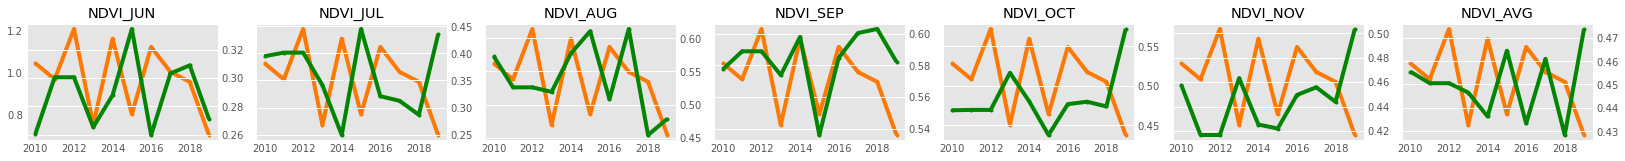

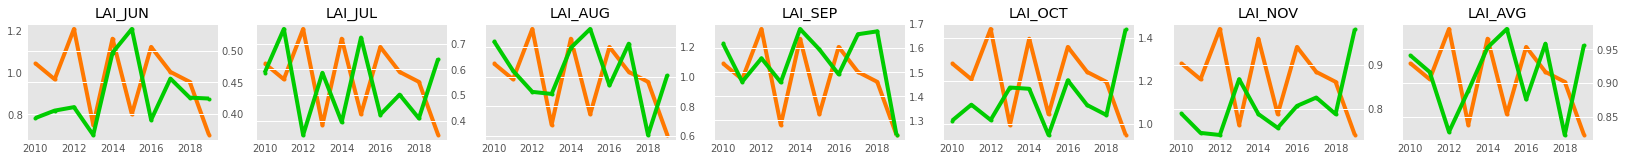

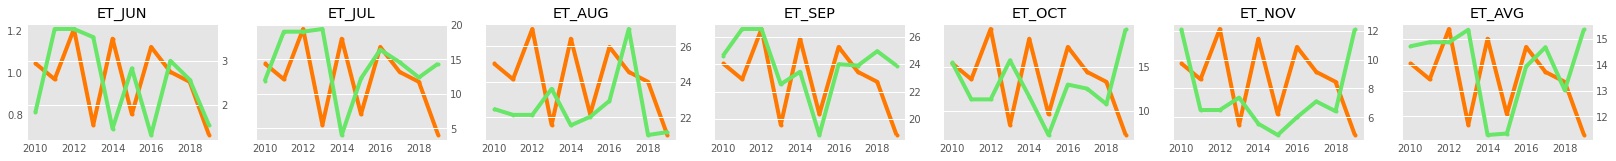

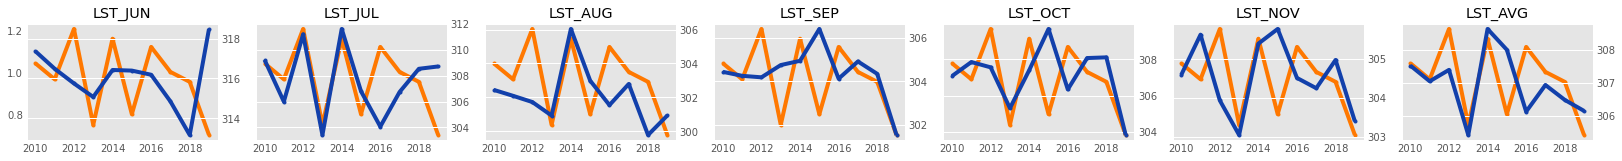

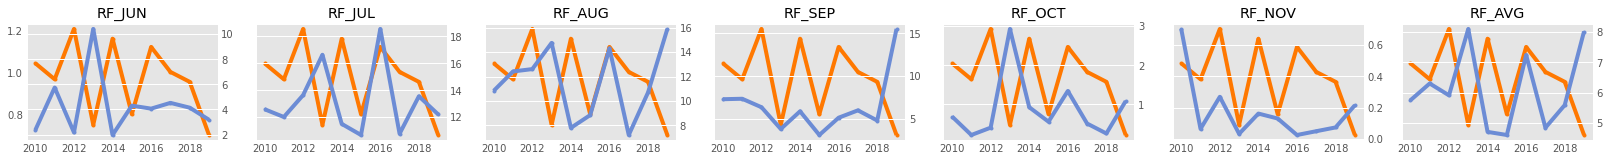

In [8]:
# Plotting the yearly feature averages by Districts
df1 = df.groupby(['YEAR'])['YIELD'].mean()

for feat in list_feats[:-1]:
    _, ax = plt.subplots(1,7,figsize = (25,2), sharey = True)
    for i, period in enumerate(list_periods+['AVG']):
        df2 = df.groupby(['YEAR'])[f'{feat}_{period}'].mean()
        _ = df1.plot(ax = ax[i], color = dict_colors['YIELD'], style = '.-', title = f'{feat}_{period}')
        _ = df2.plot(ax = ax[i], color = dict_colors[feat], style = '.-', secondary_y = True)
        _ = ax[i].set_xlabel('')

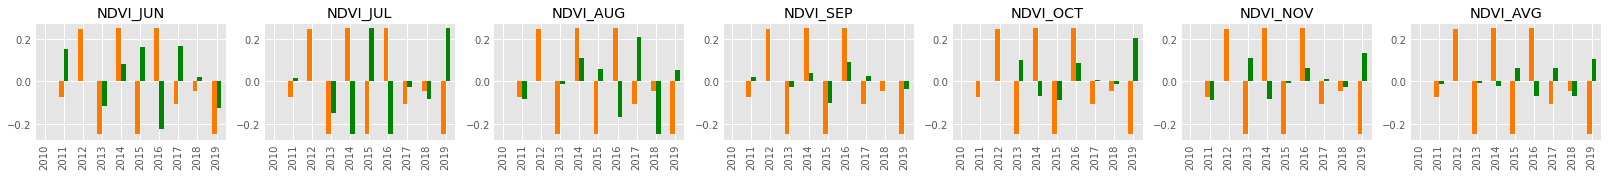

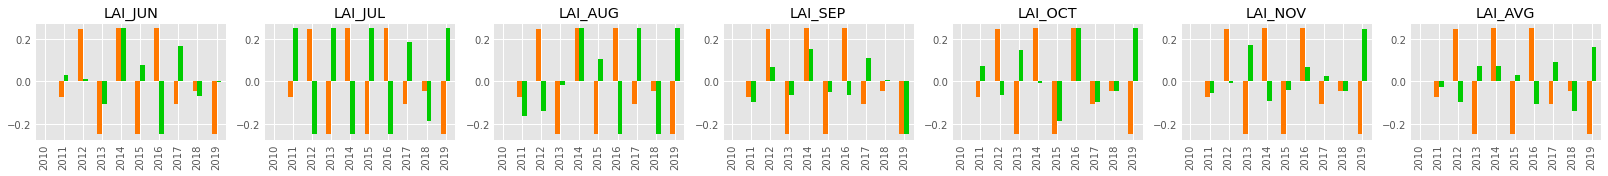

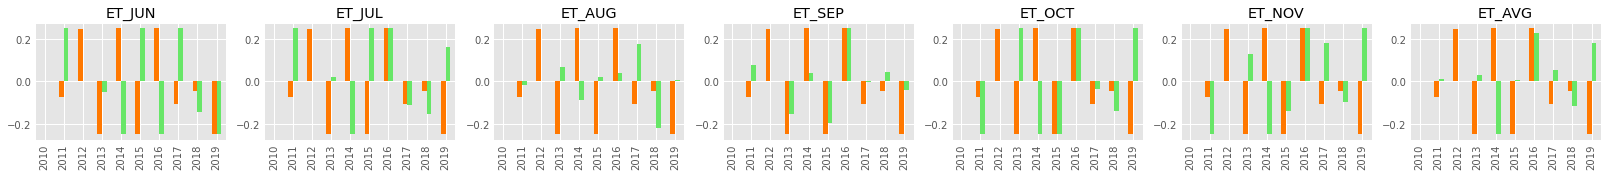

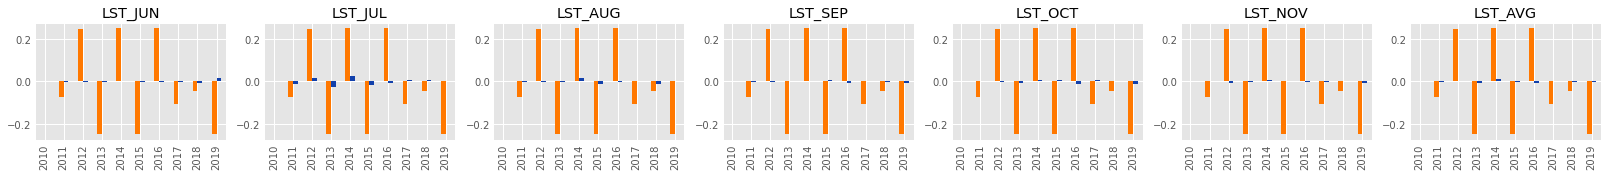

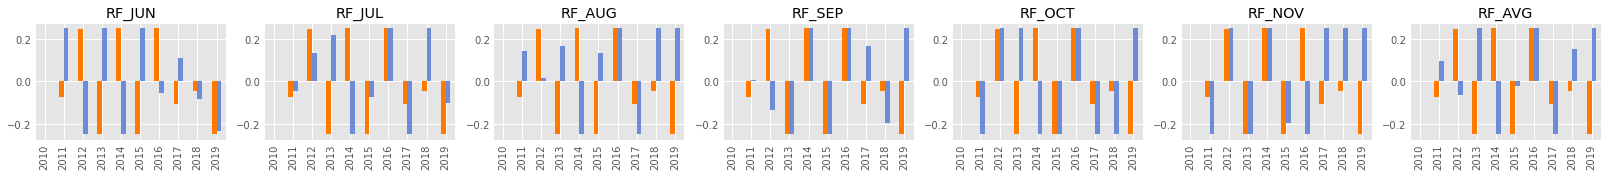

In [9]:
# Plotting the yearly percent differences of feature averages by Districts
clip_perc = 0.25
for feat in list_feats[:-1]:
    _, ax = plt.subplots(1,7,figsize = (25,2))
    for i, period in enumerate(list_periods+['AVG']):
        df2 = df.groupby(['YEAR'])['YIELD', f'{feat}_{period}'].mean().pct_change().clip(lower = -clip_perc, upper = clip_perc)
        c1, c2 = dict_colors['YIELD'], dict_colors[feat]
        _ = df2.plot(kind = 'bar', ax = ax[i], color = [c1,c2], title = f'{feat}_{period}',legend = False)
        _ = ax[i].set_xlabel('')

### 3. Univariate feature Selection

#### Correlations

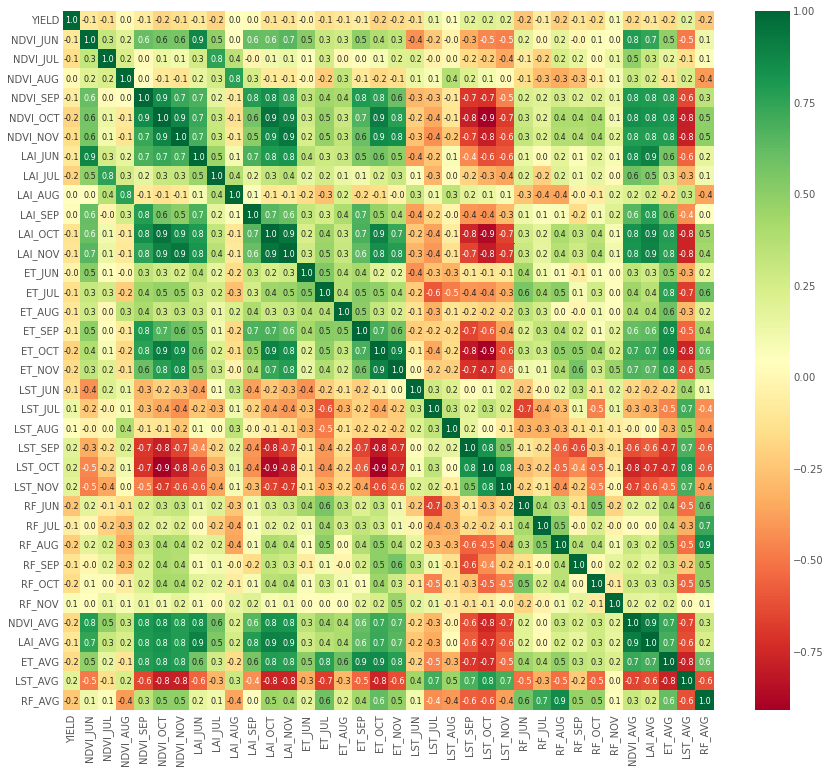

In [10]:
# Correlation matrix
df_corr = df.iloc[:,2:].corr()
_, ax = plt.subplots(figsize = (13,12))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.1f', annot_kws={"size": 8})

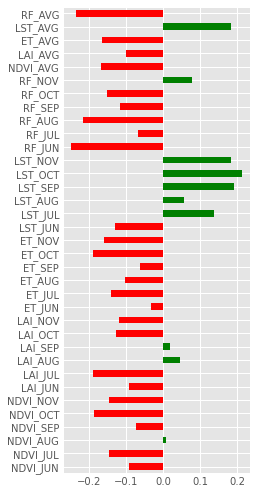

In [11]:
# Correlations
df_corr1 = df_corr['YIELD'][1:]
list1 = ['green' if x > 0 else 'red' for x in df_corr1]
_ = df_corr1.plot(kind = 'barh', figsize = (3,8), color = list1)

#### ANOVA and statistical testing

In [12]:
from scipy import stats

list_mann = list()
list_ttest = list()
list_kruskal = list()
list_anova = list()

df['YIELD_CUT'] = pd.qcut(df.YIELD, 2)
for feat in list_feats_all:
    data = df.groupby('YIELD_CUT')[feat].agg(lambda x: list(x))
    list_mann.append(stats.mannwhitneyu(*data)[1])
    list_ttest.append(stats.ttest_ind(*data)[1])
    list_kruskal.append(stats.kruskal(*data)[1])

for cat in [3,4,5,6]:
    df['YIELD_CUT'] = pd.qcut(df.YIELD, cat)
    list_anova.append([])
    for feat in list_feats_all:
        data = df.groupby('YIELD_CUT')[feat].agg(lambda x: list(x))
        fvalue, pvalue = stats.f_oneway(*data)
        list_anova[cat-3].append(pvalue)
    
df_stat = pd.DataFrame({
    'feat': list_feats_all,
    'mann': list_mann,
    'ttest': list_ttest,
    'kruskal': list_kruskal,
    'anova3': list_anova[0],
    'anova4': list_anova[1],
    'anova5': list_anova[2],
    'anova6': list_anova[3],
})
# _ = df_stat.set_index('feat').plot(kind = 'barh', figsize = (3,8))
del df['YIELD_CUT']

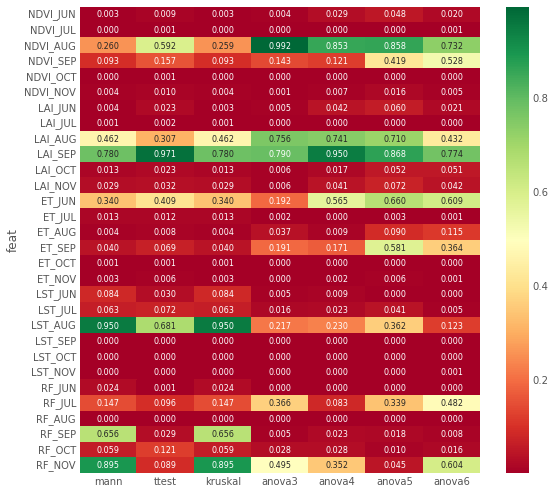

In [13]:
_, ax = plt.subplots(figsize = (8,8))
_ = sns.heatmap(df_stat.set_index('feat'), ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.3f', annot_kws={"size": 8})

### 4. Modelling

In [113]:
# Sets creation
import random
# random.seed(1234)

feat_target = 'YIELD'
feats_used = list(df.columns[3:])

filt_fold  = df.DISTRICTS.isin(random.sample(list_regions, k = 10))

filt_train = ~filt_fold
filt_valid = filt_fold

x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]

In [114]:
list_scores = list()

#### Simple method

In [115]:
# We selected the most useful features: LST_OCT, RF_JUN 
# these features are not correlated with each other
# Then we will create independent linear models and make simple average of them as prediction

feats = [
    'LST_OCT',
    'RF_JUN',
]
df_out = yv.reset_index()
del df_out['index']
df_out['pred'] = 0

for i, feat in enumerate(feats):
    p = np.poly1d(np.polyfit(x[feat], y, 1))
    print(feat, p)
    
    pred = xv[feat].map(p).values
    df_out['pred'+str(i)] = pred
    df_out['pred'] = df_out.pred + pred
    print(metrics.mean_absolute_error(yv, pred))
    
df_out['pred'] = df_out['pred']/len(feats)

LST_OCT  
0.02975 x - 8.169
0.32651649297548047
RF_JUN  
-0.03317 x + 1.111
0.31452878071798873


In [116]:
# MAE on validation set
y_pred = df_out.pred
score1 = metrics.mean_absolute_error(yv, y_pred)
list_scores.append(score1)
print(score1)

0.318288763950237


#### Linear model

In [117]:
from sklearn import linear_model

# scaler
scaler = preprocessing.StandardScaler()
scaler.fit(x)
x1 = pd.DataFrame(scaler.transform(x), columns = x.columns)
xv1 = pd.DataFrame(scaler.transform(xv), columns = x.columns)

In [118]:
model_lr = linear_model.Ridge()
_ = model_lr.fit(x1, y)

In [119]:
# MAE on validation set
y_pred = model_lr.predict(xv1)
score1 = metrics.mean_absolute_error(yv, y_pred)
list_scores.append(score1)
print(score1)

0.29673941530222125


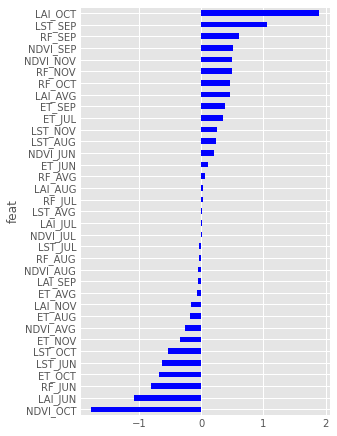

In [120]:
# Feature coefs
df_imp = pd.Series(model_lr.coef_, index = feats_used)
df_imp = df_imp/sum(df_imp)
df_imp = df_imp.reset_index()
df_imp.rename(columns={'index':'feat',0:'imp'}, inplace = True)
df_imp = df_imp.sort_values(by = 'imp')
p = df_imp.set_index('feat').imp.plot(kind = 'barh', figsize = (4,7), color = 'blue')

#### Xgboost

In [121]:
# Training process
import xgboost as xgb
x_ = xgb.DMatrix(x.values, 
                label = y, 
                feature_names = feats_used)
xv_ = xgb.DMatrix(xv.values, 
                label = yv, 
                feature_names = feats_used) 

params = {
        'booster': 'gbtree',
        'tree_method': 'hist',
        'objective': 'reg:squarederror', 
        # 'eval_metric': 'logloss',
        'eta': 0.01,
        'max_depth': 5,  # -1 means no limit
        'subsample': 1,  # Subsample ratio of the training instance.
        'colsample_bytree': 1,  # Subsample ratio of columns when constructing each tree.
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': -1,
        'verbosity': 0
    }       


early_stopping_rounds = 10
num_boost_round       = 500

evals_results = dict()
model_xgb = xgb.train(params, 
             x_, 
             evals=[
                 (x_,'train'), 
                 (xv_,'valid'),
             ], 
             evals_result=evals_results, 
             num_boost_round=num_boost_round,
             early_stopping_rounds=early_stopping_rounds,
             verbose_eval=1000)

[0]	train-rmse:0.61818	valid-rmse:0.60900
[215]	train-rmse:0.19787	valid-rmse:0.41211


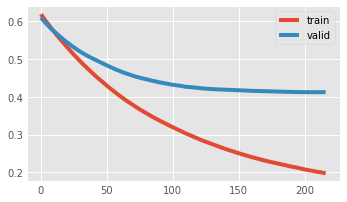

In [122]:
# Learning curve
df_evals = pd.DataFrame({
            'train': evals_results['train']['rmse'],
            'valid': evals_results['valid']['rmse'],
})
_ = df_evals.plot(figsize = (5,3))

In [123]:
# MAE on validation set
y_pred = model_xgb.predict(xv_)
score1 = metrics.mean_absolute_error(yv, y_pred)
list_scores.append(score1)
print(score1)

0.33484968408327104


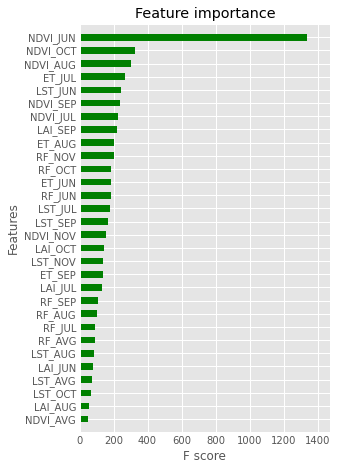

In [124]:
# Feature importances
_, ax = plt.subplots(1,1, figsize = (4,7))
_ = xgb.plot_importance(model_xgb, ax = ax, max_num_features=30, height=0.5, 
                        show_values=False, color = 'green')

#### Random forest

In [125]:
from sklearn import ensemble

model_rf = ensemble.RandomForestRegressor(n_estimators=500, max_depth=None, n_jobs=-1)
_ = model_rf.fit(x, y)

In [126]:
# MAE on validation set
y_pred = model_rf.predict(xv)
score1 = metrics.mean_absolute_error(yv, y_pred)
list_scores.append(score1)
print(score1)

0.29938401587999997


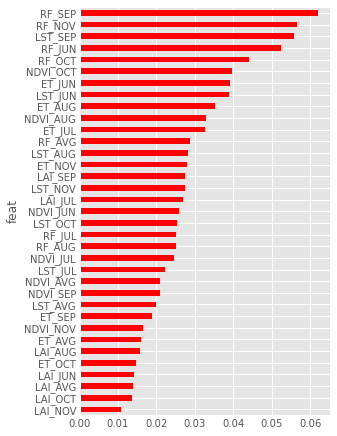

In [127]:
# Feature importances
df_imp = pd.Series(model_rf.feature_importances_, index = feats_used)
df_imp = df_imp/sum(df_imp)
df_imp = df_imp.reset_index()
df_imp.rename(columns={'index':'feat',0:'imp'}, inplace = True)
df_imp = df_imp.sort_values(by = 'imp')
p = df_imp.set_index('feat').imp.plot(kind = 'barh', figsize = (4,7), color = 'red')

#### Results

In [128]:
pd.options.display.float_format = '{:,.4f}'.format
pd.DataFrame(list_scores).T

,0,1,2,3
0,0.3183,0.2967,0.3348,0.2994
